# Text Learner++
### Written By: Nathan Pepin
### Student ID: 001195100
### Capstone Project Implementation

## Intro

This is a technical demo for a language learning tool called Text Learner++. It uses machine learning algorithms trained on the English language to extract the most important words from a text.
The text can be of practically any size, though must be in a _txt_ format.

The application is targeted at people who are learning English and want a tool to assist them in identifying vocabulary to learn before reading a text.
Language learners are usually hampered in their efforts to read a book by the overhead of needing to cross-reference.
The more time needed to look up the meaning of a word, the less comprehension of the text as a whole.

The solution as offered by this application is to reduce that overhead by giving users the top words to learn before reading a text.

## How to use

Follow the application sequentially, running and code and answering prompts as it appears.
Each section will contain some details.

## Requirements

The project requires the following to function:

- Python 3.9.5
- Jupyter notebook installation
- Web browser

## FAQ

Q: What if I get an error?

A: Most errors are caused by running the application out of order. You can determine what section should be run next by looking at the output.

---

Q: It seems to take a while when running some sections, is something wrong?

A: The program's processing time scales with the input text.
This happens because the program is separating the entire text into words and applying manipulations for each word.
Some ancient computers may struggle.

---

Q: Why is there code?

A: This is a technical demo application and will contain code to give reviewers access into the business logic.
To use the application you do not need to edit or modify any of the code.

---

Q: I changed the code on accident. What do I do?

A: If you accidentally change the code then reload the notebook or do a CTRL+Z to undo.
So long as you don't save the changes there is no harm done.

---

Q: I spotted a bug, what should I do?

A: Please report all bugs to npepin1@wgu.edu

---

Q: Why does a language learning tool for English have instructions in English?

A: This is a technical demo application and will contain code to give reviewers access into the business logic.
When in production, localizations will be provided.

# Get Input

The code below will ask you to enter a file path.
The path can be relative to the notebook or absolute, it just needs to exist.
If you receive a "File Not Found" exception, it likely means that you entered your path incorrectly.

The application will upload the text to a database.
Multiple texts can be added into the database, though only one can be analyzed at a time.

## Accepted inputs

The application only accepts *txt* files.
The *SampleData* directory in the project contain some public domain texts from https://www.gutenberg.org/ that can be used for evaluation purposes.

In [6]:
# Open DB connection
import sqlite3
connection = sqlite3.connect('database.db')

In [7]:
# Gets input
filePath = input()

# Validates input is correct format
if filePath.split('.')[1] != 'txt':
    raise  Exception("File must be .txt")

# Reads file
file = open(filePath,mode='r', encoding='utf-8')
file_text = file.read()
file.close()

# Creates the table if it doesn't exist
connection.execute('''
CREATE TABLE IF NOT EXISTS INPUT_TEXTS
(ID INTEGER PRIMARY KEY NOT NULL,
 FILE_NAME TEXT NOT NULL,
 FILE_TEXT TEXT NOT NULL);''')

# Inserts the text into the database
connection.execute('''
INSERT INTO INPUT_TEXTS (file_name, file_text) VALUES(?,?)
''', (filePath, file_text))
connection.commit()

print(f'{len(file_text)} characters from {filePath} inserted into the learning database.')

IndexError: list index out of range

# Selections

Run the code below to show what is available to select from in the database.
The selections will appear by the following order.

>{key} - {text file name}

The options may appear like:

> 3 - Moby Dick.txt
>
> 7 - Alice In Wonderland.txt
>
> 44 - Frankenstein.txt

The key for Alice In Wonderland would be 7.

In [8]:
query = connection.execute('SELECT id, file_name FROM INPUT_TEXTS')
queried_data = []
for value in query:
    queried_data.append((value[0], value[1]))
    print(f'\t{value[0]} - {value[1]}')

	1 - MB.txt


# Select a text

Using the key from above, select which text you would like to analyze.

In [9]:
# Init variables
input_text = 'Enter the text index (number) you wish to select (-1 to exit)'
textIndex = -1
continueLoop = True

# This loop will cycle until a valid input is chosen.
while continueLoop:
    textIndex = input(input_text)

    # Check for exit
    if textIndex == '-1':
        continueLoop = False
        break

    # Check if input is number
    if not textIndex.isnumeric():
        input_text = 'Error: Input text was not a number\n' \
                     'Enter the text index (number) you wish to select (-1 to exit)'
        continue

    # Check if input exists in data DB
    for it in queried_data:
        if it[0] == int(textIndex):
            textIndex = int(textIndex)
            continueLoop = False
        else:
            input_text = 'Error: Input text value was not an index\n' \
                     'Enter the text index (number) you wish to select (-1 to exit)'

print(f'Selected an index {textIndex}')

Selected an index 1


# Top words

Running the code below will analyze the text selected above and display the top 50 words in the text.
These are not simply the words that appear most in the text, but are words that appear the most and are likely to have the most meaning.

Words are also condensed into their overall meaning. For instance, "gave" and "give" are the same word but in a different tense.
The application will convert all instances of "gave" to present tense "give" and treat them as a single instance.

## Install dependencies
Run the code below to download the langauge models. This may take some time.

In [11]:
import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natep\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Code

For those that are competent with Python some values can be adjusted, such as the *bottom_range* and *top_range* variables, which control how many top words are displayed.

Note that though adjusting these values may function here, but may cause errors down the line.
For instance, if you query for the top 5 words, you will receive an error in a later section that displays the top 10 words.

## Note

This application may take some time to run, but in most cases will take less than 10 minutes, likely 30-120 seconds.

In [12]:
bottom_range = 0
top_range = 50

# Query text
all_of_it = ''
textQuery = connection.execute('''
SELECT file_text FROM input_texts WHERE ID = ?;
''', (textIndex,))
all_of_it = textQuery.fetchone()[0]

# Remove markdown
removed_markdown = all_of_it.replace('_', "")\
    .replace('*', "")\
    .replace("#", "")\
    .replace("=", "")\
    .replace('-', "")

# Remove punctuations
punctuation_tokenizer = nltk.RegexpTokenizer(r"\w+")
removed_punctuation = punctuation_tokenizer.tokenize(removed_markdown)

# Filter stop words
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
removed_stop_words = []
for word in removed_punctuation:
    if word.casefold() not in stop_words:
        removed_stop_words.append(word)

# Remove numbers
removed_numbers = []
for word in removed_stop_words:
    if word.isnumeric() is False:
        removed_numbers.append(word)
removed_numbers

# Remove proper nouns
removed_proper_nouns = []
parts_of_speach = nltk.pos_tag(removed_numbers)
for word, tag in parts_of_speach:
    if tag != "NNP" and tag != "NNPS":
        removed_proper_nouns.append(word)
removed_proper_nouns

# Lemmatizing
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in removed_proper_nouns]

# Frequency
frequency_list = nltk.FreqDist(w for w in lemmatized_words).most_common(500)
top_50_words =  [frequency_list[it] for it in range(bottom_range, top_range)]
top_50_words

[('whale', 1032),
 ('one', 906),
 ('like', 561),
 ('upon', 541),
 ('ship', 539),
 ('man', 481),
 ('sea', 445),
 ('ye', 434),
 ('old', 431),
 ('boat', 429),
 ('time', 429),
 ('would', 419),
 ('though', 335),
 ('thing', 322),
 ('hand', 320),
 ('head', 314),
 ('long', 309),
 ('said', 304),
 ('still', 299),
 ('yet', 299),
 ('must', 292),
 ('great', 291),
 ('way', 287),
 ('two', 284),
 ('seemed', 283),
 ('say', 280),
 ('last', 277),
 ('see', 258),
 ('little', 247),
 ('may', 245),
 ('round', 244),
 ('day', 241),
 ('go', 239),
 ('eye', 238),
 ('three', 234),
 ('men', 232),
 ('water', 232),
 ('thou', 231),
 ('u', 229),
 ('every', 222),
 ('much', 219),
 ('could', 216),
 ('side', 216),
 ('first', 211),
 ('come', 204),
 ('never', 196),
 ('part', 195),
 ('ever', 191),
 ('almost', 188),
 ('might', 183)]

# Word Distribution

Running the code in this section will display the frequency count for those words throughout the text.
This can be used to identify what words should be prioritized.

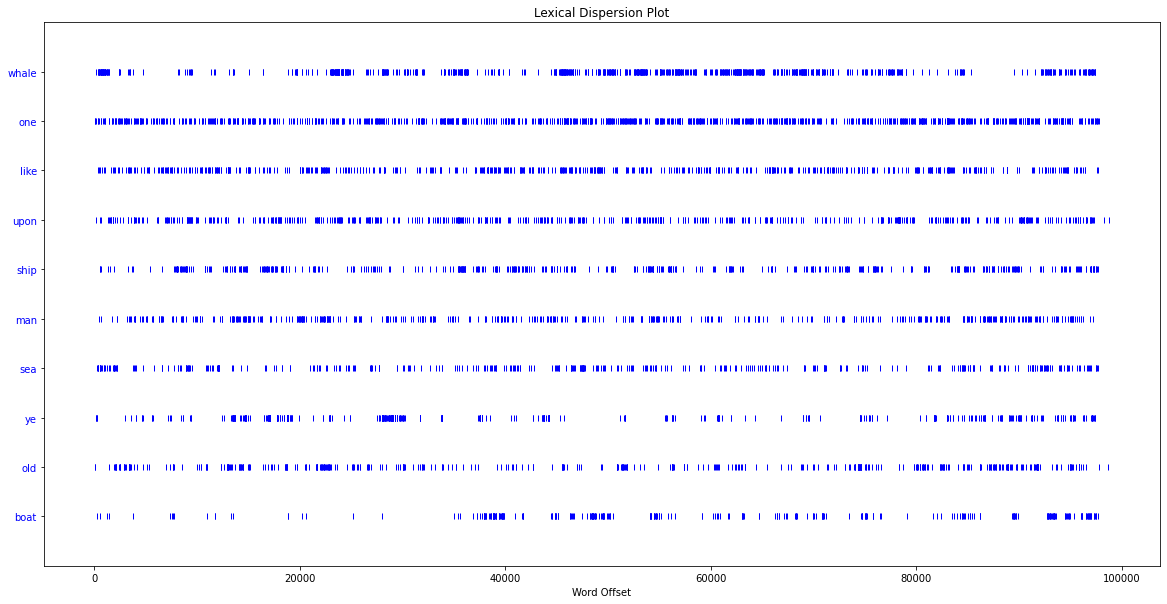

In [13]:
from nltk.text import Text

text = Text(removed_proper_nouns)
top_10_just_words = [it[0] for it in top_50_words[0:10]]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

plot = text.dispersion_plot(top_10_just_words)

# Sentiment

It can be helpful to understand the sentiment of a text to gain a fuller context.
The measure below can give a basic gauge as to what you should be experiencing while reading.
If the text is extremely positive, and you are depressed reading it, it could imply an issue with comprehensive.

The sentiment categories are as follows:
- Positive: Words that are generally happy or optimistic. An uplifting story is likely to have a high positive bias.
- Neutral: Words that are neither happy nor sad. A scientific text book is likely to take a neutral bias.
- Negative: Words that are generally sad or pessimistic. A story about a tragedy is likely to have a negative bias.

Sentiment measurements are not foolproof.
For instance a text which sarcastically details the joys of office politics may display a positive sentiment,
but in reality it is likely to be very negative.

Running the code below will determine the sentiment of your chosen text.

## Note

This application may take some time to run, but in most cases will take less than 10 minutes, likely 30-300 seconds.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sentiment = sia.polarity_scores(all_of_it)

print(f'Positive: {sentiment["pos"]}')
print(f'Neutral: {sentiment["neu"]}')
print(f'Negative: {sentiment["neg"]}')

# Tips and advice

Run the application with as many texts as you want, worst you can find out is that a text is out of your league.
It may be a good strategy to analyze texts to identify what may or may not be a good read.
A text with too many words that are unknown is likely to take a lot of preparation,
but a text where you know a good portion of the words is likely to be easier.

Remember that the purpose of learning a language is not to memorize words, but it is rather to converse and understand.
The point of learning the words is to comprehend the text.
Do not attempt to learn every word, aim for 50-80% familiarity.

If you find yourself needing to remind yourself of what a word means,
or it is a word that you don't think you've ever seen,
don't beat yourself up as this will happen even with texts in your native tongue.